## LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(15532) #for reproducibility


Bad key text.latex.unicode in file C:\Users\Paul Mathivon\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file C:\Users\Paul Mathivon\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file C:\Users\Paul Mathivon\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
http

## Problem Description
We have a csv file *train_auto* which we will use for training and evaluation of our code, as well as a *test_auto* file in which the columns **TARGET_FLAG** and **TARGET_AMT** are empty. Our goal is to predict **TARGET_FLAG** which takes value 1 or 0.

## Data Exploration

In [2]:
df=pd.read_csv("train_auto.csv",index_col="INDEX")

df.drop("TARGET_AMT", axis=1,inplace=True) #We won't be able to use "TARGET_AMT" on test_auto, so we can drop it
df.head(5)

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
2,0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
4,0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
5,0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
6,0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [3]:
df.columns[:]

Index(['TARGET_FLAG', 'KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
       'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'TRAVTIME',
       'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR', 'OLDCLAIM',
       'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')

We can see that our dataset contains both numerical and categorical data. As well as some NaN values. Let's first take a look at our categorical data :

In [4]:
df[["PARENT1","MSTATUS","SEX","EDUCATION","JOB","CAR_USE","CAR_TYPE","RED_CAR","REVOKED","URBANICITY"]].apply(pd.Series.nunique)

PARENT1       2
MSTATUS       2
SEX           2
EDUCATION     5
JOB           8
CAR_USE       2
CAR_TYPE      6
RED_CAR       2
REVOKED       2
URBANICITY    2
dtype: int64

We observe that the columns **EDUCATION**,**JOB** and **CAR_TYPE** contains more than 2 values. We will have to deal with them differently. Supposing that the features are not too correlated, we could fill the binary features with **0** and **1**. 

Let's now take a look at missing values

In [5]:
df.isnull().sum()[df.isnull().sum()>0] #all the columns with missing values 

AGE           6
YOJ         454
INCOME      445
HOME_VAL    464
JOB         526
CAR_AGE     510
dtype: int64

Our dataset contains many missing values. We should try to impute them in order to avoid loosing too much data. Using a rule of thumb for the training, we will first get rid of the rows which contains at least 2 NaNs. We loose 20 rows in the process. 

In [6]:
df.dropna(axis=0,thresh=22,inplace=True)

## DATA PREPROCESSING

In [7]:
df = df.fillna(-1) #using -1 to avoid dealing with NaN too often

First let's make our binary categorical data numerical. As well as transforming dollars into floats.

In [8]:
#transform binary categorical data in 0 and 1
df["PARENT1"].replace(("No","Yes"),(0,1),inplace=True)
df["SEX"].replace(("M","z_F"),(0,1),inplace=True)
df["CAR_USE"].replace(("Private","Commercial"),(0,1),inplace=True)
df["RED_CAR"].replace(("no","yes"),(0,1),inplace=True)
df["REVOKED"].replace(("No","Yes"),(0,1),inplace=True)
df["URBANICITY"].replace(("z_Highly Rural/ Rural","Highly Urban/ Urban"),(0,1),inplace=True)
df["MSTATUS"].replace(("z_No","Yes"),(0,1),inplace=True)

In [9]:
#transforming dollars in float
def dollar_to_float(x):
    if x == -1:
        return -1
    else:
        return np.float(x[1:].replace(",",""))   
df["INCOME"]=df["INCOME"].apply(dollar_to_float)
df["BLUEBOOK"]=df["BLUEBOOK"].apply(dollar_to_float)
df["HOME_VAL"]=df["HOME_VAL"].apply(dollar_to_float)
df["OLDCLAIM"]=df["OLDCLAIM"].apply(dollar_to_float)

After those transformations, we still have to deal with the categorical data, and the missing values in Job. Let's start by modifying categorical data. We are, first going to replace each category by the ratio of ones in **TARGET_FLAG**. For instance, if we take the item "Doctor" in the **JOB** column, we will replace "Doctor" with the percentage of 1's in the lines in which **JOB** takes the value "Doctor". We first implement a function FreqTransform that creates a dictionnary associating an item with the relative frequency.

In [10]:
def FreqTransform(target_flag,col):
    
    col
    unique_val=col[col!=-1].unique() #Not using missing values
    values=[]
    
    for val in unique_val:
        new_val = target_flag[col==val].mean()
        values.append(new_val)
    dict_val = {unique_val[i]:values[i] for i in range(len(unique_val))}
    col=col.replace(to_replace=dict_val) #we replace with the correct values
    return col,dict_val

Let's take a look at the different values taken for each category

In [11]:
dict_job=FreqTransform(df["TARGET_FLAG"],df["JOB"])[1]
dict_car_type=FreqTransform(df["TARGET_FLAG"],df["CAR_TYPE"])[1]
dict_education=FreqTransform(df["TARGET_FLAG"],df["EDUCATION"])[1]

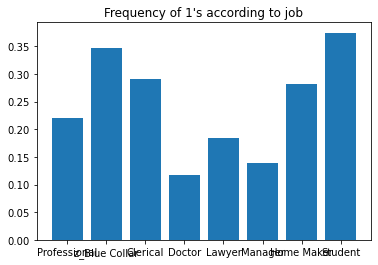

In [12]:
fig=plt.bar(range(len(dict_job)),list(dict_job.values()))
fig=plt.xticks(range(len(dict_job)), list(dict_job.keys()))
fig=plt.title("Frequency of 1's according to job")

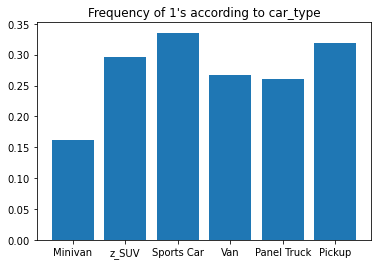

In [13]:
fig=plt.bar(range(len(dict_car_type)),list(dict_car_type.values()))
fig=plt.xticks(range(len(dict_car_type)), list(dict_car_type.keys()))
fig=plt.title("Frequency of 1's according to car_type")

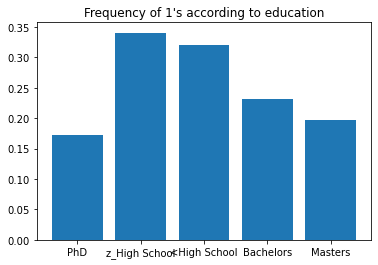

In [14]:
fig=plt.bar(range(len(dict_education)),list(dict_education.values()))
fig=plt.xticks(range(len(dict_education)), list(dict_education.keys()))
fig=plt.title("Frequency of 1's according to education")

It seems that we could split the Education and Job features in two groups accordingly to the relative frequence of 1's in **Target_Flag**. 

For instance, education could be split into **"Higher Education"** (Bachelor, Master, Phd) and **"Basic Education"** (z_High School, High School). Job could be split into **"Specialized Job"** (Doctor, Lawyer, Manager, Professional) and **"Basic job"** (Clerical, Blue Collar worker, Student,Home Maker). Thus allowing us to use binary data.

A distinction is not so easily made for the car type, and we could just use the relative frequency as our new variable.

In [15]:
#transforming into binary data
df["EDUCATION"].replace(to_replace=["Masters","PhD","Bachelors"],value=1,inplace=True)
df["EDUCATION"].replace(to_replace=["z_High School","<High School"],value=0,inplace=True)

In [16]:
df["JOB"].replace(to_replace=["Lawyer","Doctor","Manager","Professional"],value=1,inplace=True)
df["JOB"].replace(to_replace=["Home Maker","Student","z_Blue Collar","Clerical"],value=0,inplace=True)

In [17]:

#Transforming into relative frequency
df["CAR_TYPE"]= FreqTransform(df["TARGET_FLAG"],df["CAR_TYPE"])[0]

Now that we only have numerical data (binary or continuous), we can use sklearn KNN imputer to impute the missing values.

In [18]:
#Imputing Age,YOJ,Income,Home_val and CAR_AGE,JOB
from sklearn.impute import KNNImputer
df_2 = df.drop(["TARGET_FLAG"],axis=1) 
#TARGET_FLAG won't be available in our testing sample
imputer=KNNImputer(n_neighbors= 15,missing_values=-1.,weights='distance') #Nearest Neighbors Imputer
impute=imputer.fit_transform(df_2)
df[df_2.columns]=impute

We now have numerical data that is free from missing values. Considering this, we should try to linearize and normalize it. Let's first check if we find colinearity in our data that would need us to rectify it using cross-terms.

In [19]:
np.round(df.corr(),3)

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
TARGET_FLAG,1.000,0.104,-0.103,0.115,-0.071,-0.139,0.158,-0.180,-0.135,0.022,...,-0.104,-0.082,0.145,-0.008,0.139,0.216,0.153,0.219,-0.100,0.224
KIDSDRIV,0.104,1.000,-0.074,0.463,0.041,-0.044,0.198,-0.020,0.041,0.046,...,-0.023,-0.002,0.017,-0.045,0.021,0.038,0.044,0.054,-0.053,-0.036
AGE,-0.103,-0.074,1.000,-0.444,0.132,0.177,-0.314,0.207,0.091,-0.066,...,0.166,-0.001,-0.022,0.020,-0.030,-0.025,-0.039,-0.072,0.174,0.051
HOMEKIDS,0.115,0.463,-0.444,1.000,0.080,-0.154,0.449,-0.109,0.043,0.112,...,-0.108,0.012,0.057,-0.068,0.030,0.030,0.045,0.061,-0.151,-0.063
YOJ,-0.071,0.041,0.132,0.080,1.000,0.286,-0.050,0.271,0.140,-0.088,...,0.153,0.022,-0.076,0.051,-0.005,-0.029,-0.006,-0.039,0.062,0.082
INCOME,-0.139,-0.044,0.177,-0.154,0.286,1.000,-0.073,0.559,-0.031,-0.107,...,0.437,0.001,-0.114,0.059,-0.045,-0.048,-0.020,-0.062,0.405,0.200
PARENT1,0.158,0.198,-0.314,0.449,-0.050,-0.073,1.000,-0.255,-0.478,0.074,...,-0.050,-0.001,0.030,-0.042,0.035,0.049,0.050,0.069,-0.063,-0.022
HOME_VAL,-0.180,-0.020,0.207,-0.109,0.271,0.559,-0.255,1.000,0.444,-0.072,...,0.268,0.004,-0.070,0.016,-0.072,-0.094,-0.049,-0.084,0.218,0.118
MSTATUS,-0.135,0.041,0.091,0.043,0.140,-0.031,-0.478,0.444,1.000,0.004,...,-0.008,-0.001,0.004,-0.018,-0.046,-0.070,-0.044,-0.048,-0.028,-0.003
SEX,0.022,0.046,-0.066,0.112,-0.088,-0.107,0.074,-0.072,0.004,1.000,...,-0.063,-0.006,0.323,-0.667,0.001,-0.012,0.002,0.008,-0.020,-0.053


First, we can observe that some features seem to be mostly uncorrelated to **TARGET_FLAG**. It is for instance the case of **RED_CAR** and **SEX**. It is unlikely that those features could help us predict **TARGET_FLAG** and they could induce overfitting of the training data. We can therefore drop them.

Second, there does not seem to be too much correlation amongst the features. We can however notice that **OLDCLAIM** is correlated with  **CLM_FREQ**,**REVOKED** and **MVR_PTS**, and **CLM_FREQ** with **MVR_PTS**. We can thus add some first order cross features for those features.

In [20]:
df.drop(["RED_CAR","SEX"],axis=1,inplace=True)
df["OLDCLAIM*CLM_FREQ"]= df["OLDCLAIM"]*df["CLM_FREQ"]
df["OLDCLAIM*REVOKED"] =  df["OLDCLAIM"]*df["REVOKED"]
df["OLDCLAIM*MVR_PTS"] =  df["OLDCLAIM"]*df["MVR_PTS"]
df["CLM_FREQ*MVR_PTS"] = df["CLM_FREQ"]*df["MVR_PTS"]

## MODEL TRAINING
We will now train some algorithm on the data in order to predict **TARGET_FLAG**.

It is important to remark that **TARGET_FLAG** contains approximately 75% of 0's. So it is important to keep in mind that an algorithm that would return O independantly from the features would still be 75% accurate. We should therefore also take a look at the True Positive, False Positive and False Negative rates.

First, let's rescale our data. We will use the *MinMaxScaler* from sklearn. Then we can divide it into a training and a testing sample

In [21]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split as tts
y=df["TARGET_FLAG"]
y= y.to_numpy()
X=df.drop("TARGET_FLAG",axis=1)
x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x) #automatically rescale our numerical data
X = pd.DataFrame(x_scaled,columns=X.columns)
#X.drop(["TIF","YOJ","TRAVTIME"],axis=1,inplace=True)
X=X.to_numpy()
X_train,X_test,y_train,y_test= tts(X,y,train_size=.75,stratify=y) 
#we stratify on **TARGET_FLAG** to have the most representative data in both our training and testing samples

Now let's try different algorithms :

### GRADIENT BOOSTING CLASSIFIER

I chose to first try a gradient boosting classifier. It seemed that a max_depth of 2 limited overfitting while allowing for a good predictive rate. 

Using a large validation_fraction helps avoiding overfitting, as well as choosing a smaller learning-rate.

In [22]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
model_GBC=GBC(n_estimators=300,learning_rate=0.1,max_depth=2,validation_fraction=0.4) 

model_GBC = model_GBC.fit(X_train,y_train)

In [23]:
print("train_sample accuracy "+ np.str(np.round(model_GBC.score(X_train,y_train),4)))
print("test_sample accuracy "+ np.str(np.round(model_GBC.score(X_test,y_test),4)))

train_sample accuracy 0.8256
test_sample accuracy 0.7952


We can see that this models overfits a bit. However, the precision on the test_samble seems to be bounded by 80%.
Let's have a look at the confusion matrix.

In [24]:
from sklearn.metrics import confusion_matrix as cm
tn,fp,fn,tp = cm(y_test,model_GBC.predict(X_test),normalize='true').ravel()
print ("TN = ",tn)
print ("FP = ",fp)
print ("FN = ",fn)
print ("TP = ",tp)

TN =  0.9172781854569713
FP =  0.08272181454302868
FN =  0.5456238361266295
TP =  0.4543761638733706


### Keras Neural Network

Here is a neural network created with tensorflow.keras. I decided to use a feed forward network with 3 *Dense* layers containing neurons each. Which is close to our data dimension. 

I increased the number of layers until I observed  an important overfitting of the data. Overfitting appeared with three hidden layers. After that, I adjusted the batch size to diminish overfitting and I then added Dropout layers and tweaked the dropout rate parameter until there was no overfitting. 

In [25]:
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD

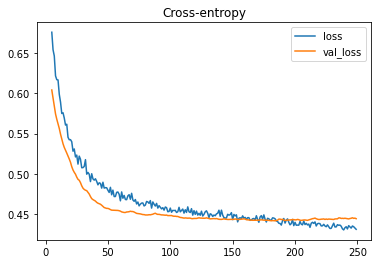

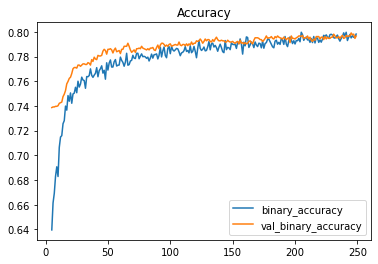

In [26]:
model_NN = keras.Sequential([layers.Dense(32,input_dim=25,activation="relu"),
                         layers.BatchNormalization(),
                         layers.Dropout(rate=0.3),
                         layers.Dense(32,activation="relu"),
                         layers.BatchNormalization(),
                         layers.Dropout(rate=0.3),
                         layers.Dense(32,activation="relu"),
                         layers.BatchNormalization(),
                         layers.Dropout(rate=0.4),
                         layers.Dense(units=1,activation="sigmoid")])



model_NN.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=["binary_accuracy"])

early_stopping = keras.callbacks.EarlyStopping(
    patience=30,
    min_delta=0.00001,
    restore_best_weights=True,
)
history = model_NN.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=700,
    epochs=250,
    #callbacks=[early_stopping],
    verbose=0,shuffle=True
)

history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot(title="Cross-entropy")
fig=history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [27]:
history_df["binary_accuracy"].max()

0.7996724247932434

## Conclusion for the training part

Considering the whole dataset and its link to insurance, we can suppose that **TARGET_FLAG** is a risk indicator that is used by insurers (based on previous accidents, etc...). The neural network output is a sigmoïd and we can thus use it as a probability measure for the risk. We can also output probability from the *GBC*.  

In the case were we are trying to predict the risk for new clients, it could be interesting to see whether the most dangerous profiles (i.e : the profiles with the highest probability) can be detected. Moreover, we could try to see if we are not missing risky individuals.

Let's empirically compute the following probabilities :
$$P_{low,NN}=P(p_{y,NN}<0.2 | TFG=1)$$
$$P_{low,GBC}=P(p_{y,GBC}<0.2 |TFG=1)$$
$$P_{high,NN}=P(TFG=1 | p_{y,NN}>0.8)$$
$$P_{high,GBC}=P(TFG=1 |  p_{y,GBC}>0.8)$$

The *low* probabilities are the probabilities that a risky individual receive a low score (under 20%). It is thus the probability that we underestimate the risk. This probability should be as low as possible.

The *high* probabilities correspond to the probability that an individual that receive a high score (above 80%) is indeed a risky individual.It should be as high as possible.

In [28]:
Y_GBC = model_GBC.predict_proba(X_test) 
Y_NN = model_NN.predict(X_test)

In [29]:
risk_df=pd.DataFrame(data = y_test,columns=["TARGET_FLAG"])
risk_df["Y_GBC"]=Y_GBC[:,1]
risk_df["Y_NN"]=Y_NN

In [30]:
risk_df.head()

,TARGET_FLAG,Y_GBC,Y_NN
0,0,0.135988,0.183095
1,0,0.093525,0.109849
2,0,0.111928,0.158873
3,1,0.458435,0.429687
4,0,0.359747,0.406633


In [31]:
p_low_nn=len(risk_df[(risk_df["TARGET_FLAG"]==1)&(risk_df["Y_NN"]<=0.2)])/len(risk_df[risk_df["TARGET_FLAG"]==1])
p_low_gbc=len(risk_df[(risk_df["TARGET_FLAG"]==1)&(risk_df["Y_GBC"]<=0.2)])/len(risk_df[risk_df["TARGET_FLAG"]==1])

In [32]:
p_high_nn=len(risk_df[(risk_df["TARGET_FLAG"]==1)&(risk_df["Y_NN"]>=0.8)])/len(risk_df[risk_df["Y_NN"]>=0.8])
p_high_gbc=len(risk_df[(risk_df["TARGET_FLAG"]==1)&(risk_df["Y_GBC"]>=0.8)])/len(risk_df[risk_df["Y_GBC"]>=0.8])

In [33]:
print("For the NN :")
print("low prob nn p = ",np.round(p_low_nn,3))
print("high prob nn p = ",np.round(p_high_nn,3))
print("")
print("For the GBC :")
print("low prob gbc p = ",np.round(p_low_gbc,3))
print("high prob gbc p = ",np.round(p_high_gbc,3))

For the NN :
low prob nn p =  0.184
high prob nn p =  0.741

For the GBC :
low prob gbc p =  0.145
high prob gbc p =  0.827


**Conclusion:**

GBC attributes higher probabilities to dangerous individuals. The models are comparable for attributing low risk to dangerous individuals.

It therefore seems that the Gradient Boosting Classifier is more efficient separating risky individuals from less dangerous ones. We should therefore prefer it to the Neural Network. 

However, we should mind the fact that 15% percent of people  who receive a very low score are, in fact, "dangerous drivers".

## PREDICTION ON THE TEST AUTO DATASET

First we train our GBC on the whole dataset train_auto. Our choice of parameters limited overfitting during the training. We can be confident that we can still limit it while learning on the whole dataset. It could improve our prediction

In [34]:
model_GBC=GBC(n_estimators=300,learning_rate=0.1,max_depth=2,validation_fraction=0.4)
model_GBC = model_GBC.fit(X,y)

In [35]:
test_auto = pd.read_csv("test_auto.csv",index_col="INDEX")
test_auto.drop(["TARGET_FLAG","TARGET_AMT"],axis=1,inplace=True)
test_auto.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
3,0,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,...,"$21,970",1,Van,yes,$0,0,No,2,10.0,Highly Urban/ Urban
9,1,40.0,1,11.0,"$50,815",Yes,$0,z_No,M,z_High School,...,"$18,930",6,Minivan,no,"$3,295",1,No,2,1.0,Highly Urban/ Urban
10,0,44.0,2,12.0,"$43,486",Yes,$0,z_No,z_F,z_High School,...,"$5,900",10,z_SUV,no,$0,0,No,0,10.0,z_Highly Rural/ Rural
18,0,35.0,2,NaN,"$21,204",Yes,$0,z_No,M,z_High School,...,"$9,230",6,Pickup,no,$0,0,Yes,0,4.0,z_Highly Rural/ Rural
21,0,59.0,0,12.0,"$87,460",No,$0,z_No,M,z_High School,...,"$15,420",1,Minivan,yes,"$44,857",2,No,4,1.0,Highly Urban/ Urban


In [36]:
test_auto = pd.read_csv("test_auto.csv",index_col="INDEX")
test_auto.drop(["TARGET_FLAG","TARGET_AMT"],axis=1,inplace=True)
test_auto = test_auto.fillna(-1) #using -1 to avoid dealing with NaN too often

#transform binary categorical data in 0 and 1
test_auto["PARENT1"]=test_auto["PARENT1"].replace(to_replace=("No","Yes"),value=(0,1))
test_auto["SEX"].replace(("M","z_F"),(0,1),inplace=True)
test_auto["CAR_USE"].replace(("Private","Commercial"),(0,1),inplace=True)
test_auto["RED_CAR"].replace(("no","yes"),(0,1),inplace=True)
test_auto["REVOKED"].replace(("No","Yes"),(0,1),inplace=True)
test_auto["URBANICITY"].replace(("z_Highly Rural/ Rural","Highly Urban/ Urban"),(0,1),inplace=True)
test_auto["MSTATUS"].replace(("z_No","Yes"),(0,1),inplace=True)
#transforming dollars in float
test_auto["INCOME"]=test_auto["INCOME"].apply(dollar_to_float)
test_auto["BLUEBOOK"]=test_auto["BLUEBOOK"].apply(dollar_to_float)
test_auto["HOME_VAL"]=test_auto["HOME_VAL"].apply(dollar_to_float)
test_auto["OLDCLAIM"]=test_auto["OLDCLAIM"].apply(dollar_to_float)
#transforming EDUCATION into binary data
test_auto["EDUCATION"].replace(to_replace=["Masters","PhD","Bachelors"],value=1,inplace=True)
test_auto["EDUCATION"].replace(to_replace=["z_High School","<High School"],value=0,inplace=True)
#Transforming JOB into binary data
test_auto["JOB"].replace(to_replace=["Lawyer","Doctor","Manager","Professional"],value=1,inplace=True)
test_auto["JOB"].replace(to_replace=["Home Maker","Student","z_Blue Collar","Clerical"],value=0,inplace=True)
#Transforming into relative frequency
test_auto["CAR_TYPE"].replace(dict_car_type,inplace=True)

#Imputing Age,YOJ,Income,Home_val and CAR_AGE,JOB
imputer=KNNImputer(n_neighbors= 15,missing_values=-1.,weights='distance') #Nearest Neighbors Imputer
impute=imputer.fit_transform(test_auto)
test_auto[test_auto.columns]=impute
test_auto.drop(["RED_CAR","SEX"],axis=1,inplace=True)
test_auto["OLDCLAIM*CLM_FREQ"]= test_auto["OLDCLAIM"]*test_auto["CLM_FREQ"]
test_auto["OLDCLAIM*REVOKED"] =  test_auto["OLDCLAIM"]*test_auto["REVOKED"]
test_auto["OLDCLAIM*MVR_PTS"] =  test_auto["OLDCLAIM"]*test_auto["MVR_PTS"]
test_auto["CLM_FREQ*MVR_PTS"] = test_auto["CLM_FREQ"]*test_auto["MVR_PTS"]


x = test_auto.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x) #automatically rescale our numerical data
X = pd.DataFrame(x_scaled,columns=test_auto.columns)
#X.drop(["TIF","YOJ","TRAVTIME"],axis=1,inplace=True)
X=X.to_numpy()
Y= model_GBC.predict(X)

In [37]:
output = pd.DataFrame(index=test_auto.index,columns=["p_target"])
output["p_target"]=Y

In [38]:
output.to_csv("output.csv")